🚀 Your First AI Agent: From Prompt to Action¶
Welcome to the Kaggle 5-day Agents course!

This notebook is your first step into building AI agents. An agent can do more than just respond to a prompt — it can take actions to find information or get things done.

In this notebook, you'll:

✅ Install Agent Development Kit (ADK)
✅ Configure your API key to use the Gemini model
✅ Build your first simple agent
✅ Run your agent and watch it use a tool (like Google Search) to answer a question

⚙️ Section 1: Setup¶
1.1: Install dependencies
The Kaggle Notebooks environment includes a pre-installed version of the google-adk library for Python and its required dependencies, so you don't need to install additional packages in this notebook.

To install and use ADK in your own Python development environment outside of this course, you can do so by running:

pip install google-adk
1.2: Configure your Gemini API Key
This notebook uses the Gemini API, which requires authentication.

1. Get your API key

If you don't have one already, create an API key in Google AI Studio.

2. Add the key to Kaggle Secrets

Next, you will need to add your API key to your Kaggle Notebook as a Kaggle User Secret.

In the top menu bar of the notebook editor, select Add-ons then Secrets.
Create a new secret with the label GOOGLE_API_KEY.
Paste your API key into the "Value" field and click "Save".
Ensure that the checkbox next to GOOGLE_API_KEY is selected so that the secret is attached to the notebook.
3. Authenticate in the notebook

Run the cell below to complete authentication.

In [26]:
import os
#from kaggle_secrets import UserSecretsClient

try:
   #GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
    GOOGLE_API_KEY=os.environ["GOOGLE_API_KEY"]  
    print("✅ Gemini API key setup complete.")
except Exception as e:
    print(
        f"🔑 Authentication Error: Please make sure you have added 'GOOGLE_API_KEY' to your Kaggle secrets. Details: {e}"
    )

✅ Gemini API key setup complete.


1.3: Import ADK components¶
Now, import the specific components you'll need from the Agent Development Kit and the Generative AI library. This keeps your code organized and ensures we have access to the necessary building blocks.

In [27]:
from google.adk.agents import Agent
from google.adk.models.google_llm import Gemini
from google.adk.runners import InMemoryRunner
from google.adk.tools import google_search
from google.genai import types

print("✅ ADK components imported successfully.")

✅ ADK components imported successfully.


1.4: Helper functions
We'll define some helper functions. If you are running this outside the Kaggle environment, you don't need to do this.

In [30]:
# Define helper functions that will be reused throughout the notebook
import jupyter_server
from IPython.core.display import display, HTML
from jupyter_server.serverapp import list_running_servers


# Gets the proxied URL in the Kaggle Notebooks environment
def get_adk_proxy_url():
    PROXY_HOST = "https://kkb-production.jupyter-proxy.kaggle.net"
    ADK_PORT = "8000"

    servers = list(list_running_servers())
    if not servers:
        raise Exception("No running Jupyter servers found.")

    baseURL = servers[0]["base_url"]

    try:
        path_parts = baseURL.split("/")
        kernel = path_parts[2]
        token = path_parts[3]
    except IndexError:
        raise Exception(f"Could not parse kernel/token from base URL: {baseURL}")

    url_prefix = f"/k/{kernel}/{token}/proxy/proxy/{ADK_PORT}"
    url = f"{PROXY_HOST}{url_prefix}"

    styled_html = f"""
    <div style="padding: 15px; border: 2px solid #f0ad4e; border-radius: 8px; background-color: #fef9f0; margin: 20px 0;">
        <div style="font-family: sans-serif; margin-bottom: 12px; color: #333; font-size: 1.1em;">
            <strong>⚠️ IMPORTANT: Action Required</strong>
        </div>
        <div style="font-family: sans-serif; margin-bottom: 15px; color: #333; line-height: 1.5;">
            The ADK web UI is <strong>not running yet</strong>. You must start it in the next cell.
            <ol style="margin-top: 10px; padding-left: 20px;">
                <li style="margin-bottom: 5px;"><strong>Run the next cell</strong> (the one with <code>!adk web ...</code>) to start the ADK web UI.</li>
                <li style="margin-bottom: 5px;">Wait for that cell to show it is "Running" (it will not "complete").</li>
                <li>Once it's running, <strong>return to this button</strong> and click it to open the UI.</li>
            </ol>
            <em style="font-size: 0.9em; color: #555;">(If you click the button before running the next cell, you will get a 500 error.)</em>
        </div>
        <a href='{url}' target='_blank' style="
            display: inline-block; background-color: #1a73e8; color: white; padding: 10px 20px;
            text-decoration: none; border-radius: 25px; font-family: sans-serif; font-weight: 500;
            box-shadow: 0 2px 5px rgba(0,0,0,0.2); transition: all 0.2s ease;">
            Open ADK Web UI (after running cell below) ↗
        </a>
    </div>
    """

    display(HTML(styled_html))

    return url_prefix


print("✅ Helper functions defined.")

C:\Users\bernh\AppData\Local\Temp\ipykernel_23884\2571413694.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


✅ Helper functions defined.


1.5: Configure Retry Options
When working with LLMs, you may encounter transient errors like rate limits or temporary service unavailability. Retry options automatically handle these failures by retrying the request with exponential backoff.

In [31]:
retry_config=types.HttpRetryOptions(
    attempts=5,  # Maximum retry attempts
    exp_base=7,  # Delay multiplier
    initial_delay=1, # Initial delay before first retry (in seconds)
    http_status_codes=[429, 500, 503, 504] # Retry on these HTTP errors
)


🤖 Section 2: Your first AI Agent with ADK¶
🤔 2.1 What is an AI Agent?
You've probably used an LLM like Gemini before, where you give it a prompt and it gives you a text response.

Prompt -> LLM -> Text

An AI Agent takes this one step further. An agent can think, take actions, and observe the results of those actions to give you a better answer.

Prompt -> Agent -> Thought -> Action -> Observation -> Final Answer

In this notebook, we'll build an agent that can take the action of searching Google. Let's see the difference!

2.2 Define your agent
Now, let's build our agent. We'll configure an Agent by setting its key properties, which tell it what to do and how to operate.

To learn more, check out the documentation related to agents in ADK.

These are the main properties we'll set:

name and description: A simple name and description to identify our agent.
model: The specific LLM that will power the agent's reasoning. We'll use "gemini-2.5-flash-lite".
instruction: The agent's guiding prompt. This tells the agent what its goal is and how to behave.
tools: A list of tools that the agent can use. To start, we'll give it the google_search tool, which lets it find up-to-date information online.


In [32]:
root_agent = Agent(
    name="helpful_assistant",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    description="A simple agent that can answer general questions.",
    instruction="You are a helpful assistant. Use Google Search for current info or if unsure.",
    tools=[google_search],
)

print("✅ Root Agent defined.")

✅ Root Agent defined.


2.3 Run your agent
Now it's time to bring your agent to life and send it a query. To do this, you need a Runner, which is the central component within ADK that acts as the orchestrator. It manages the conversation, sends our messages to the agent, and handles its responses.

a. Create an InMemoryRunner and tell it to use our root_agent:

In [33]:
runner = InMemoryRunner(agent=root_agent)

print("✅ Runner created.")

✅ Runner created.


👉 Note that we are using the Python Runner directly in this notebook. You can also run agents using ADK command-line tools such as adk run, adk web, or adk api_server. To learn more, check out the documentation related to runtime in ADK.

b. Now you can call the .run_debug() method to send our prompt and get an answer.

👉 This method abstracts the process of session creation and maintenance and is used in prototyping. We'll explore "what sessions are and how to create them" on Day 3

In [34]:
response = await runner.run_debug(
    "What is Agent Development Kit from Google? What languages is the SDK available in?"
)


 ### Created new session: debug_session_id

User > What is Agent Development Kit from Google? What languages is the SDK available in?
helpful_assistant > The Agent Development Kit (ADK) from Google is a flexible and modular framework designed to simplify the development and deployment of AI agents and multi-agent systems. It applies software development principles to AI agent creation, allowing developers to define agent logic, tools, and orchestration directly in code. This code-first approach provides robust debugging, reliable versioning, and deployment freedom. ADK is optimized for Gemini and the Google ecosystem but is model-agnostic and compatible with other frameworks.

The ADK is available in the following programming languages:
*   **Python**
*   **Go**
*   **Java**


You can see a summary of ADK and its available languages in the response.

2.4 How does it work?
The agent performed a Google Search to get the latest information about ADK, and it knew to use this tool because:

The agent inspects and is aware of which tools it has available to use.
The agent's instructions specify the use of the search tool to get current information or if it is unsure of an answer.
The best way to see the full, detailed trace of the agent's thoughts and actions is in the ADK web UI, which we'll set up later in this notebook.

And we'll cover more detailed workflows for logging and observability later in the course.

🚀 2.5 Your Turn!
This is your chance to see the agent in action. Ask it a question that requires current information.

Try one of these, or make up your own:

What's the weather in London?
Who won the last soccer world cup?
What new movies are showing in theaters now?


In [35]:
response = await runner.run_debug("What's the weather in London?")


 ### Continue session: debug_session_id

User > What's the weather in London?
helpful_assistant > The weather in London is currently mostly cloudy with a temperature of 49°F (9°C). There is a 0% chance of rain today, with humidity around 89%.

The forecast for the next 10 days indicates a mix of cloudy skies and light rain, with temperatures generally ranging from the low 40s°F to the high 50s°F. Tonight, the low is expected to be around 48°F, with a 15% chance of rain. For Tuesday, November 12th, the forecast is light rain during the day and at night, with temperatures between 57°F and 60°F and a 45% chance of rain during the day and 20% at night.


💻 Section 3: Try the ADK Web Interface¶
Overview
ADK includes a built-in web interface for interactively chatting with, testing, and debugging your agents.
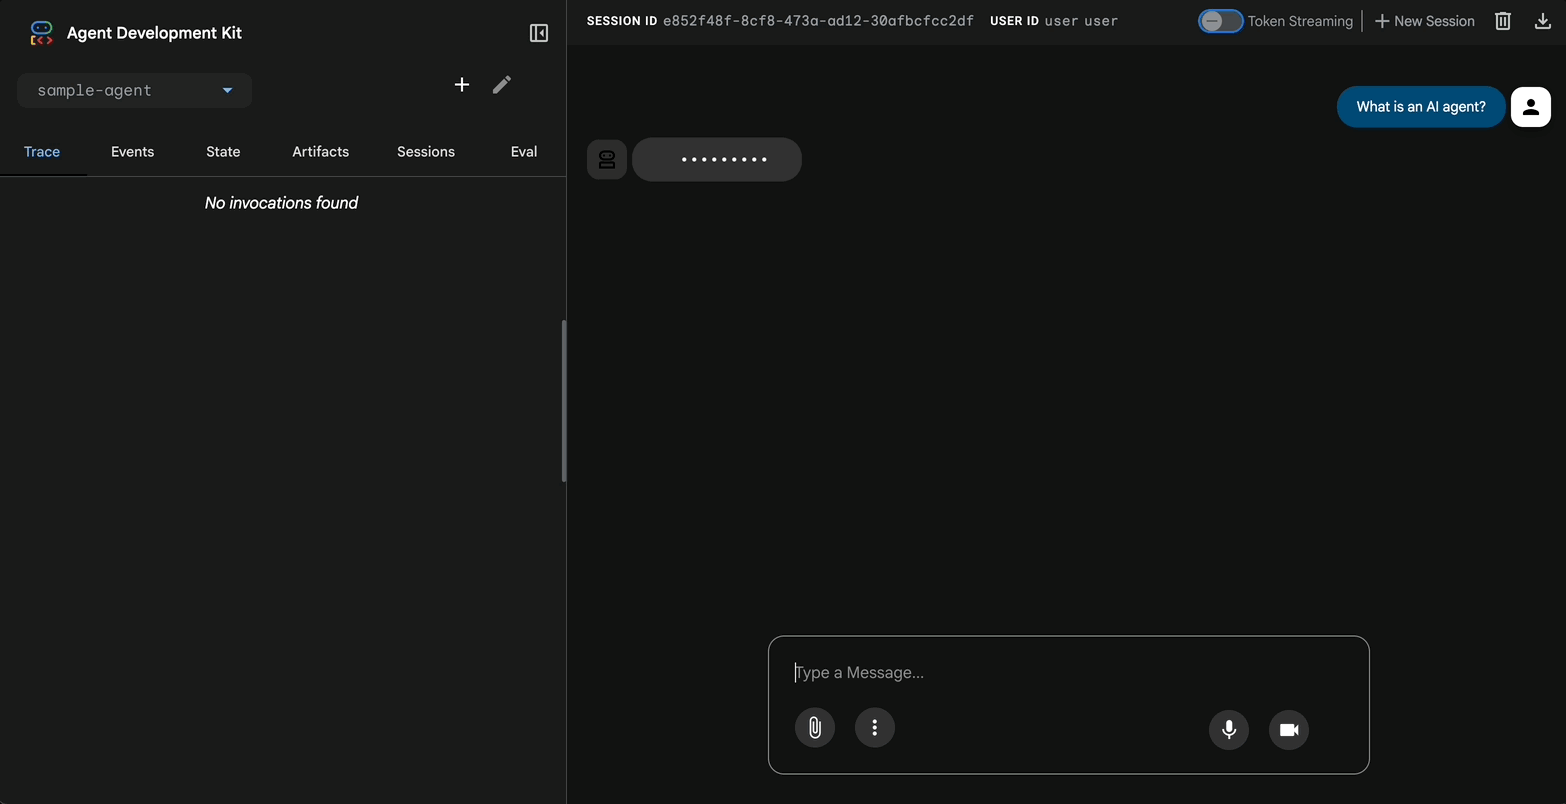

To use the ADK web UI, you'll need to create an agent with Python files using the adk create command.

Run the command below to generate a sample-agent folder that contains all the necessary files, including agent.py for your code, an .env file with your API key pre-configured, and an __init__.py file:

In [ ]:
!adk create sample-agent --model gemini-2.5-flash-lite --api_key $GOOGLE_API_KEY


Agent created in c:\Users\bernh\Documentos\GitHub\RagLight\13_google_agentic\sample-agent:
- .env
- __init__.py
- agent.py



Get your custom URL to access the ADK web UI in the Kaggle Notebooks environment:

In [41]:
import jupyter_server
url_prefix = get_adk_proxy_url()

Exception: No running Jupyter servers found.

In [39]:
!adk web --url_prefix {url_prefix}


^C


Now you can access the ADK dev UI using the link above.

Once you open the link, you'll see the ADK web interface where you can ask your ADK agent questions.

Note: This sample agent does not have any tools enabled (like Google Search). It is a basic agent designed specifically to let you explore the UI features.

‼️ IMPORTANT: DO NOT SHARE THE PROXY LINK with anyone - treat it as sensitive data as it contains your authentication token in the URL.

✅ Congratulations!
You've built and run your first agent with ADK! You've just seen the core concept of agent development in action.

The big takeaway is that your agent didn't just respond—it reasoned that it needed more information and then acted by using a tool. This ability to take action is the foundation of all agent-based AI.

ℹ️ Note: No submission required!

This notebook is for your hands-on practice and learning only. You do not need to submit it anywhere to complete the course.

📚 Learn More
Refer to the following documentation to learn more:

ADK Documentation
ADK Quickstart for Python
ADK Agents Overview
ADK Tools Overview
🎯 Next Steps
Ready for the next challenge? Continue to the next notebook to learn how to architect multi-agent systems.